# Introduction

This is an example on how to implement logistic regression to predict wheather a client will subscribe to a term deposit as a result of direct marketing campaigns (phone calls). The dataset if from the UIC Machine Learning Repository.

# About Logistic Regression

Logistic regression is basically a machine learning classification algorithm used to predict the probability of a categorical dependent variable. Thus, it predicts P(Y=1) as a function of x. Note that the dependent variable is binary (0 or 1).

**Main Assumptions**

1. Independent variables should have no multicollinearity
2. Independent variables have a linear relationship to log odds
3. Sample sizes are large

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc('font',size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes = True)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Dataset

In [2]:
data = pd.read_csv('banking.CSV', header = 0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
#check for null entries
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

yippee no null values!!!

In [4]:
data.shape , list(data.columns)

((41188, 21),
 ['age',
  'job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'poutcome',
  'emp_var_rate',
  'cons_price_idx',
  'cons_conf_idx',
  'euribor3m',
  'nr_employed',
  'y'])

### Input Variables

1.age (numeric)

2.job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)

3.marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)

4.education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)

5.default: has credit in default? (categorical: “no”, “yes”, “unknown”)

6.housing: has housing loan? (categorical: “no”, “yes”, “unknown”)

7.loan: has personal loan? (categorical: “no”, “yes”, “unknown”)

8.contact: contact communication type (categorical: “cellular”, “telephone”)

9.month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)

10.day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)

11.duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model

12.campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13.pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14.previous: number of contacts performed before this campaign and for this client (numeric)

15.poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)

16.emp.var.rate: employment variation rate — (numeric)

17.cons.price.idx: consumer price index — (numeric)

18.cons.conf.idx: consumer confidence index — (numeric)

19.euribor3m: euribor 3 month rate — (numeric)

20.nr.employed: number of employees — (numeric)

**3.3.2 Target Variable**
y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

**3.3.3 Bucketing : Education**
Education has many categories. We are going to reduce it for better modeling.

In [5]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [6]:
# grouping basic - 4,6,9 into basic

data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])

In [7]:
#let's have look at education now

data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

# Exploratory Data Analysis

Let us understand the target variable first

In [8]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

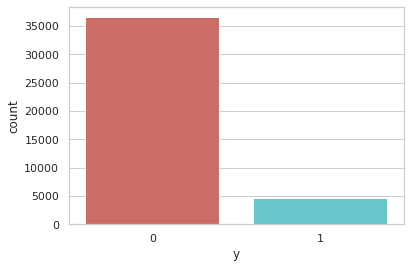

<Figure size 432x288 with 0 Axes>

In [9]:
sns.countplot(x='y',data=data,palette='hls')
plt.show()
plt.savefig('count_plot')

Thus we have 36548 cases of 'no success', and '4640' cases of success.

Let us understand how the mean values are, for both the classes.

In [10]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


# Data Visualization

**1. Purchase by job type**

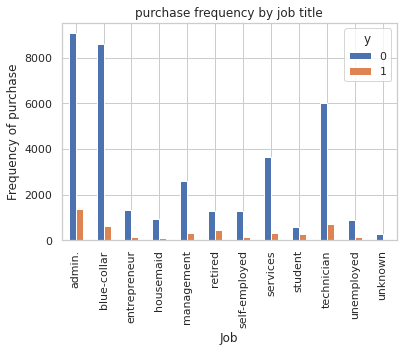

In [11]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('purchase frequency by job title')
plt.xlabel('Job')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_job')

Thus jobs seem to be an important predictor variable.

**2. Purchase by marital status**

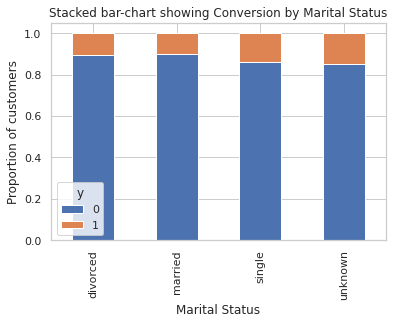

In [12]:
table = pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('Stacked bar-chart showing Conversion by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of customers')
plt.savefig('purchase_by_ms')

THere is not variation within each of the classes, and hence doesnt seem to be an important predictor variable.

**3. Purchase by education**

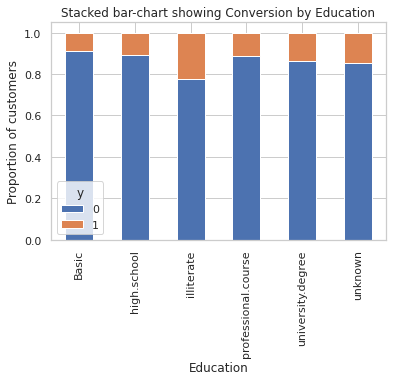

In [13]:
table = pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)
plt.title('Stacked bar-chart showing Conversion by Education')
plt.xlabel('Education')
plt.ylabel('Proportion of customers')
plt.savefig('purchase_by_edu')

Education seems to be important in predicting the success - illiterate people being convinced more by such marketing calls.

**4. Purchase quality by Month**

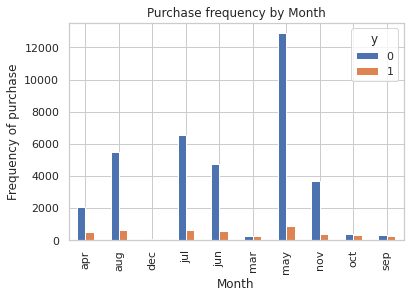

In [14]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase frequency by Month')
plt.xlabel('Month')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_mnt')

The number of conversions seem to be seasonal, and months seem to play an important role.

**5. Understanding the day of week effect**

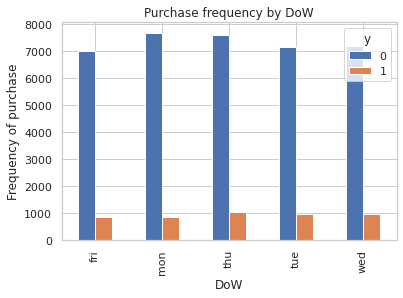

In [15]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase frequency by DoW')
plt.xlabel('DoW')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_DOW')

Thus Day of Week doen't seem to contain much information, and hence might not be a good predictor variable.

**6. Purchase frequency by Previous outcomes**

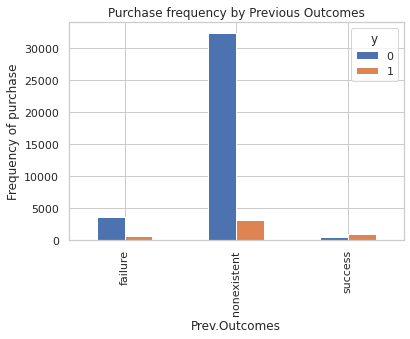

In [16]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase frequency by Previous Outcomes')
plt.xlabel('Prev.Outcomes')
plt.ylabel('Frequency of purchase')
plt.savefig('purchase_by_pout')

Thus, new target customers seem to convert more. Also, previous outcomes seem to be an important variable in prediction.

# Creating Dummy Variables

Since lot of fields are categorical, let us code them into dummy variables. These dummy variables contain binary values

In [17]:
categorical_variable_cols = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

for var in categorical_variable_cols:
    categ_list = 'var_' + var
    categ_list = pd.get_dummies(data[var],prefix = var)
    data1=data.join(categ_list)
    data = data1
data.info()
## Creating feilds to keep
#data_vars = data.columns.values.tolist()
#to_keep=[i for i in data_vars if i not in categorical_variable_cols]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   job                            41188 non-null  object 
 2   marital                        41188 non-null  object 
 3   education                      41188 non-null  object 
 4   default                        41188 non-null  object 
 5   housing                        41188 non-null  object 
 6   loan                           41188 non-null  object 
 7   contact                        41188 non-null  object 
 8   month                          41188 non-null  object 
 9   day_of_week                    41188 non-null  object 
 10  duration                       41188 non-null  int64  
 11  campaign                       41188 non-null  int64  
 12  pdays                          41188 non-null 

In [18]:
c1 = categorical_variable_cols[:6]
c2 = categorical_variable_cols[6:]
data_final = data.drop(c1, axis = 1)
data_final = data_final.drop(c2, axis = 1)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp_var_rate                   41188 non-null  float64
 6   cons_price_idx                 41188 non-null  float64
 7   cons_conf_idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr_employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_admin.                     41188 non-null  uint8  
 12  job_blue-collar                41188 non-null 

In [19]:
data_final_vars = data_final.columns.values.tolist()
y = ['y']
X = [i for i in data_final_vars if i not in y]

In [20]:
y

['y']

In [21]:
X

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_Basic',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_t

# Feature Selection

For the purpose of feature selection, the method impletened here is RFE (Recursive Feature Elimination).

RFE selects features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a featureimportances attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [22]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(data_final[X], data_final[y])
Selected_Features_Support = list(rfe.support_)
Selected_Features_rank = list(rfe.ranking_)

print(Selected_Features_Support)
print(Selected_Features_rank)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

[False, False, False, False, True, False, False, False, True, False, False, True, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, True, True, False, False, True, True, True, True, False, False, True, False, False, False, True, True, True]
[33, 31, 11, 35, 1, 16, 22, 18, 1, 30, 29, 1, 5, 36, 39, 1, 40, 2, 1, 23, 27, 43, 32, 26, 13, 42, 6, 7, 41, 8, 25, 12, 1, 20, 44, 34, 38, 14, 15, 37, 24, 1, 21, 1, 1, 1, 4, 17, 1, 1, 1, 1, 19, 28, 1, 10, 9, 3, 1, 1, 1]


The RFE has helped us select the following features: “previous”, “euribor3m”, “job_blue-collar”, “job_retired”, “job_services”, “job_student”, “default_no”, “month_aug”, “month_dec”, “month_jul”, “month_nov”, “month_oct”, “month_sep”, “day_of_week_fri”, “day_of_week_wed”, “poutcome_failure”, “poutcome_nonexistent”, “poutcome_success”.

Selecting only these columns:

In [23]:
columns_final = ["previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 
      "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", 
      "poutcome_failure", "poutcome_nonexistent", "poutcome_success"] 

X = data_final[columns_final]
y = data_final['y']

# Model Implementataion

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

creating final model:

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting the test set results, and calculating the accuracy

In [26]:
y_pred = logreg.predict(X_test)

## Calculating the accuracy

print('Accuracy of logistic regression classifier on test set: {:2f}'.format(logreg.score(X_test,y_test)))

Accuracy of logistic regression classifier on test set: 0.900461


## Cross Validation to make sure that the model generalizes well

In-order to make sure that the model doesn't overfit, we will do a 10-fold CV to train our logistic regression model.

In [27]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits = 10, random_state = 7)

modelCV = LogisticRegression()

scoring = 'accuracy'

results = model_selection.cross_val_score(modelCV, X_train,y_train, cv = kfold, scoring = scoring)

print("10-fold cross-validation average accuracy : %.3f" % (results.mean()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


10-fold cross-validation average accuracy : 0.897


Thus the average accuracy after CV is very close to the accuracy predicted from the test set.

Hence, we can conclude that our model generalizes well.

# Creating the truth table (Confusion Matrix)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10872   109]
 [ 1121   255]]


Thus, True Positive = 10872, False Positive = 1122, True Negative = 254, False Negative = 109

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

F score = 2 (Precision Recall)/(Precision + Recall)

Calculating Precission, Recall & F1 score

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10981
           1       0.70      0.19      0.29      1376

    accuracy                           0.90     12357
   macro avg       0.80      0.59      0.62     12357
weighted avg       0.88      0.90      0.87     12357



Thus the model has a high overall precision and recall, and F-score.